Notebook by Paul Scotti with code adapted from 
Aidan Dempster (https://github.com/Veldrovive/open_clip)

In particular, please somebody try out the various networks Aidan shared (https://github.com/Veldrovive/open_clip/blob/main/src/open_clip/model.py) which includes more complex architectures like transformers and architectures that handle both 2D and 3D voxels.

I also have a DistributedDataParallel version of this notebook for anyone who might want to use this with multi-gpu on Slurm (just ask me for it).

# Import packages & functions

In [ ]:
# # Download checkpoints from huggingface
# !wget -c https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/main/checkpoints/clip_image_vit_subj01_epoch20.pth
# !wget -c https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/main/checkpoints/clip_text_vit_subj01_epoch20.pth
# !wget -c https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/main/checkpoints/clip_text_resnet_subj01_epoch42.pth

In [1]:
import os
import sys
import math
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms
from tqdm import tqdm
import PIL
from datetime import datetime
import h5py
import webdataset as wds
from info_nce import InfoNCE
import clip

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

mean=np.array([0.48145466, 0.4578275, 0.40821073])
std=np.array([0.26862954, 0.26130258, 0.27577711])
denorm = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def np_to_Image(x):
    return PIL.Image.fromarray((x.transpose(1, 2, 0)*127.5+128).clip(0,255).astype('uint8'))
def torch_to_Image(x,device=device):
    x = denorm(x)
    return transforms.ToPILImage()(x)
def Image_to_torch(x):
    return (transforms.ToTensor()(x[0])[:3].unsqueeze(0)-.5)/.5
def pairwise_cosine_similarity(A, B, dim=1, eps=1e-8):
    #https://stackoverflow.com/questions/67199317/pytorch-cosine-similarity-nxn-elements
    numerator = A @ B.T
    A_l2 = torch.mul(A, A).sum(axis=dim)
    B_l2 = torch.mul(B, B).sum(axis=dim)
    denominator = torch.max(torch.sqrt(torch.outer(A_l2, B_l2)), torch.tensor(eps))
    return torch.div(numerator, denominator)
def batchwise_cosine_similarity(Z,B):
    # https://www.h4pz.co/blog/2021/4/2/batch-cosine-similarity-in-pytorch-or-numpy-jax-cupy-etc
    B = B.T
    Z_norm = torch.linalg.norm(Z, dim=1, keepdim=True)  # Size (n, 1).
    B_norm = torch.linalg.norm(B, dim=0, keepdim=True)  # Size (1, b).
    cosine_similarity = ((Z @ B) / (Z_norm @ B_norm)).T
    return cosine_similarity
def get_non_diagonals(a):
    a = torch.triu(a,diagonal=1)+torch.tril(a,diagonal=-1)
    # make diagonals -1
    a=a.fill_diagonal_(-1)
    return a
def topk(similarities,labels,k=5):
    if k > similarities.shape[0]:
        k = similarities.shape[0]
    topsum=0
    for i in range(k):
        topsum += torch.sum(torch.argsort(similarities,axis=1)[:,-(i+1)] == labels)/len(labels)
    return topsum

cuda


## Which pretrained model are you using for voxel alignment to embedding space? 

In [2]:
model_name = 'clip_image_vit' # CLIP ViT-L/14 image embeddings

# model_name = 'clip_text_vit' # CLIP ViT-L/14 text embeddings

# model_name = 'clip_image_resnet' # CLIP basic ResNet image embeddings

print(f"Using model: {model_name}")

Using model: clip_image_vit


In [3]:
if model_name=='clip_image_vit':
    model, preprocess = clip.load("ViT-L/14", device=device)
    emb_name = "images"
elif model_name=='clip_text_vit':
    model, preprocess = clip.load("ViT-L/14", device=device)
    emb_name = "trial"
elif model_name=='clip_image_resnet':
    model, preprocess = clip.load("RN50", device=device)
    emb_name = "images"
    
# dont want to train model
model.eval()
# dont need to calculate gradients
for param in model.parameters():
    param.requires_grad = False

if model_name=='clip_text_vit':
    f = h5py.File('/scratch/gpfs/KNORMAN/nsdgeneral_hdf5/COCO_73k_subj_indices.hdf5', 'r')
    subj01_order = f['subj01'][:]
    f.close()

    # curated the COCO annotations in the same way as the mind_reader (Lin Sprague Singh) preprint
    annots = np.load('/scratch/gpfs/KNORMAN/nsdgeneral_hdf5/COCO_73k_annots_curated.npy',allow_pickle=True)
    subj01_annots = annots[subj01_order]
    
    def text_tokenize(annots):
        for i,b in enumerate(annots):
            t = ''
            while t == '':
                rand = torch.randint(5,(1,1))[0][0]
                t = b[0,rand]
            if i==0:
                txt = np.array(t)
            else:
                txt = np.vstack((txt,t))
        txt = txt.flatten()
        return clip.tokenize(txt)
    
    def embedder(text_token):
        with torch.no_grad():
            text_features = model.encode_text(text_token.to(device))
        return text_features
else:
    def embedder(image):
        with torch.no_grad():
            image_features = model.encode_image(image.to(device))
            if "vit" in model_name: # I think this is the clamping used by Lin Sprague Singh preprint
                image_features = torch.clamp(image_features,-1.5,1.5) 
        return image_features     
    
#print(model)

# Load data

NSD webdatasets for subjects 1, 2, and 3 are publicly available here: 

https://huggingface.co/datasets/pscotti/naturalscenesdataset/tree/main/webdataset

In [4]:
# use large batches and the complete training dataset? 
full_training = True
print('full_training',full_training)

full_training True


In [36]:
preproc_vox = transforms.Compose([transforms.ToTensor(),torch.nan_to_num])

preproc_img = transforms.Compose([
                    transforms.Resize(size=(224,224)),
                    transforms.Normalize(mean=mean,
                                         std=std),
                ])

# image augmentation just for the CLIP image model that will be more semantic-focused
img_augment = transforms.Compose([
                    transforms.RandomCrop(size=(140,140)),
                    transforms.Resize(size=(224,224)),
                    transforms.RandomHorizontalFlip(p=.5),
                    transforms.ColorJitter(.4,.4,.2,.1),
                    transforms.RandomGrayscale(p=.2),
                ])

if not full_training: 
    num_devices = 1
    num_workers = 4
    print("num_workers",num_workers)
    batch_size = 16
    print("batch_size",batch_size)
    num_samples = 500 
    global_batch_size = batch_size * num_devices
    print("global_batch_size",global_batch_size)
    num_batches = math.floor(num_samples / global_batch_size)
    num_worker_batches = math.floor(num_batches / num_workers)
    print("num_worker_batches",num_worker_batches)
    train_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..1}.tar"
else:
    num_devices = torch.cuda.device_count()
    print("num_devices",num_devices)
    num_workers = num_devices * 4
    print("num_workers",num_workers)
    batch_size = 300
    print("batch_size",batch_size)
    num_samples = 24983 # see metadata.json in webdataset_split folder
    global_batch_size = batch_size * num_devices
    print("global_batch_size",global_batch_size)
    num_batches = math.floor(num_samples / global_batch_size)
    num_worker_batches = math.floor(num_batches / num_workers)
    print("num_worker_batches",num_worker_batches)
    train_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..49}.tar"

train_data = wds.DataPipeline([wds.ResampledShards(train_url),
                    wds.tarfile_to_samples(),
                    wds.shuffle(500,initial=500),
                    wds.decode("torch"),
                    wds.rename(images="jpg;png", voxels="nsdgeneral.npy", embs="sgxl_emb.npy", trial="trial.npy"),
                    wds.map_dict(images=preproc_img),
                    wds.to_tuple("voxels", emb_name),
                    wds.batched(batch_size, partial=True),
                ]).with_epoch(num_worker_batches)
train_dl = wds.WebLoader(train_data, num_workers=num_workers,
                         batch_size=None, shuffle=False, persistent_workers=True)

# Validation #
num_samples = 492
num_batches = math.ceil(num_samples / global_batch_size)
num_worker_batches = math.ceil(num_batches / num_workers)
print("validation: num_worker_batches",num_worker_batches)

url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar"
val_data = wds.DataPipeline([wds.ResampledShards(url),
                    wds.tarfile_to_samples(),
                    wds.decode("torch"),
                    wds.rename(images="jpg;png", voxels="nsdgeneral.npy", 
                                embs="sgxl_emb.npy", trial="trial.npy"),
                    wds.map_dict(images=preproc_img),
                    wds.to_tuple("voxels", emb_name),
                    wds.batched(batch_size, partial=True),
                ]).with_epoch(num_worker_batches)
val_dl = wds.WebLoader(val_data, num_workers=num_workers,
                       batch_size=None, shuffle=False, persistent_workers=True)

# check that your data loaders are working
for train_i, (voxel, emb) in enumerate(train_dl):
    print("idx",train_i)
    print("voxel.shape",voxel.shape)
    if emb_name=='images': # image embedding
        emb = emb.to(device)
    else: # text embedding
        text_tokens = text_tokenize(subj01_annots[emb]).to(device)
    print("emb.shape",emb.shape)
    emb = embedder(emb)
    print("emb.shape",emb.shape)
    out_dim = emb.shape[1]
    print("out_dim", out_dim)
    break

num_devices 1
num_workers 4
batch_size 300
global_batch_size 300
num_worker_batches 20
validation: num_worker_batches 1
idx 0
voxel.shape torch.Size([300, 15724])
emb.shape torch.Size([300, 3, 224, 224])
emb.shape torch.Size([300, 768])
out_dim 768


# Initialize network

In [6]:
class BrainNetwork(nn.Module):
    def __init__(self, out_dim, h=7861):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=0),
            nn.Dropout1d(0.1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.lin = nn.Linear(h,h)
        self.relu = nn.ReLU()
        self.lin1 = nn.Linear(251552,out_dim)
        
    def forward(self, x):
        x = x[:,None,:]
        x = self.conv(x)
        residual = x
        for res_block in range(4):
            x = self.lin(x)
            x += residual
            x = self.relu(x)
            residual = x
        x = x.reshape(len(x),-1)
        x = self.lin1(x)
        return x

# PS note: i also tried the below network and it didn't work nearly as good at the top one
# class BrainNetwork(nn.Module):
#     def __init__(self, out_dim, h=5120):
#         super().__init__()
#         self.blocks = 4
#         self.conv = nn.Sequential(
#             nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=0),
#             nn.Dropout1d(0.1),
#             nn.ReLU(),
#             nn.AdaptiveMaxPool1d(h)
#         )
#         self.lin = [nn.Linear(h,h).to(device) for blocks in range(self.blocks)]
#         self.drop = nn.Dropout1d(0.1)
#         self.norm = [nn.BatchNorm1d(32).to(device) for blocks in range(self.blocks)]
#         self.relu = [nn.ReLU() for blocks in range(self.blocks)]
#         self.lin1 = nn.Linear(163840,out_dim)
        
#     def forward(self, x):
#         x = x[:,None,:]
#         x = self.conv(x)
#         residual = x
#         for res_block in range(self.blocks):
#             x = self.lin[res_block](x)
#             x = self.drop(x)
#             x = self.norm[res_block](x)
#             x = self.relu[res_block](x)
#             x = residual + x
#             residual = x
#         x = x.reshape(len(x),-1)
#         x = self.lin1(x)
#         return x 

In [7]:
# reset rng seed
torch.manual_seed(123)
np.random.seed(123)

# init model
brain_net = BrainNetwork(out_dim)
brain_net = brain_net.to(device)

# test out that the neural network can run without error:
with torch.cuda.amp.autocast():
    out = brain_net(voxel.to(device))
    print(out.shape)

torch.Size([300, 768])


# Train model

In [8]:
if full_training:
    num_epochs = 100
else:
    num_epochs = 20

initial_learning_rate = 1e-6
optimizer = torch.optim.AdamW(brain_net.parameters(), lr=initial_learning_rate)
# optimizer = torch.optim.SGD(brain_net.parameters(), lr=initial_learning_rate, momentum=0.95)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=1e-8, patience=5) 
nce = InfoNCE() # what we will use for loss function  

# Other losses to consider: #
# Cosine Similarity:
# # full pairwise matrix approach:
# logits = pairwise_cosine_similarity(emb_.reshape(len(emb),-1),emb.reshape(len(emb),-1))
# labels = torch.arange(len(emb)).to(device)
# cos_loss = nn.functional.cross_entropy(logits, labels)
# # or more direct approach without full pairwise matrix
# cos = nn.CosineSimilarity()
# cos_loss = torch.mean(1-cos(emb_.reshape(len(emb),-1),emb.reshape(len(emb),-1)))
# # MSE Loss:
# mse = nn.MSELoss()
# mse_loss = mse(emb_,emb)

In [9]:
print(f"num_epochs:{num_epochs} batch_size:{batch_size} lr:{initial_learning_rate}")
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
print(f"Will be saving model checkpoints to checkpoints/{model_name}_subj01_epoch#.pth")

epoch = 0
train_losses = []; val_losses = []
train_percent_correct = []
val_percent_correct = []
lrs = []

# # resuming from checkpoint?
# ckpt_path = f'checkpoints/{model_name}_subj01_epoch20.pth'
# checkpoint = torch.load(ckpt_path, map_location=device)
# epoch=checkpoint['epoch']+1
# brain_net.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# train_losses=checkpoint['train_losses']
# train_percent_correct=checkpoint['train_percent_correct']
# val_losses=checkpoint['val_losses']
# val_percent_correct=checkpoint['val_percent_correct']
# lrs=checkpoint['lrs']

pbar = tqdm(range(epoch,num_epochs))
for epoch in pbar:
    brain_net.train()
    similarities = []
    for train_i, (voxel, emb) in enumerate(train_dl):
        optimizer.zero_grad()
        
        voxel = voxel.to(device)
        
        with torch.cuda.amp.autocast():
            if emb_name=='images': # image embedding
                if "resnet" in model_name:
                    emb = embedder(emb.to(device))
                else: # image augmentations for semantic-focused image model
                    emb = embedder(img_augment(emb.to(device)))
            else: # text embedding
                text_tokens = text_tokenize(subj01_annots[emb]).to(device)
                emb = embedder(text_tokens)

            emb_ = brain_net(voxel)
            if torch.any(torch.isnan(emb_)):
                raise ValueError("NaN found...")
            emb_ = nn.functional.normalize(emb_,dim=-1) # l2 normalization on the embeddings
            
            labels = torch.arange(len(emb)).to(device)
            loss = nce(emb_.reshape(len(emb),-1),emb.reshape(len(emb),-1))
            
            similarities = batchwise_cosine_similarity(emb,emb_)

            percent_correct = topk(similarities,labels,k=1)
            
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        train_percent_correct.append(percent_correct.item())
        
    brain_net.eval()    
    # using all validation samples to compute loss
    for val_i, (val_voxel, val_emb) in enumerate(val_dl):
        with torch.no_grad(): 
            val_voxel = val_voxel.to(device)
            
            with torch.cuda.amp.autocast():
                if emb_name=='images': # image embedding
                    val_emb = embedder(val_emb.to(device)) 
                else: # text embedding
                    val_text_tokens = text_tokenize(subj01_annots[val_emb]).to(device)
                    val_emb = embedder(val_text_tokens)

                val_emb_ = brain_net(val_voxel)
            
                labels = torch.arange(len(val_emb)).to(device)

                val_loss = nce(val_emb_.reshape(len(val_emb),-1),val_emb.reshape(len(val_emb),-1))

                val_similarities = batchwise_cosine_similarity(val_emb,val_emb_)

                percent_correct = topk(val_similarities,labels,k=1)
                
            val_losses.append(val_loss.item())
            val_percent_correct.append(percent_correct.item())
                
    if epoch%5==0 and full_training:
        torch.save({
            'epoch': epoch,
            'model_state_dict': brain_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_percent_correct': train_percent_correct,
            'val_percent_correct': val_percent_correct,
            'lrs': lrs,
            }, f'checkpoints/{model_name}_subj01_epoch{epoch}.pth')
            
    scheduler.step(val_loss) 
    lrs.append(optimizer.param_groups[0]['lr'])
    
    pbar.set_description(f"Loss: {np.median(train_losses[-(train_i+1):]):.3f} | VLoss: {np.median(val_losses[-(val_i+1):]):.3f}  | TopK%: {np.median(train_percent_correct[-10:]):.3f} | VTopK%: {np.median(val_percent_correct[-10:]):.3f} | lr{lrs[-1]:.5f}")
    
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

num_epochs:100 batch_size:300 lr:1e-07
2022-10-30 17:44:55
Will be saving model checkpoints to checkpoints/clip_image_vit_subj01_epoch#.pth


Loss: 3.892 | VLoss: 3.818  | TopK%: 0.432 | VTopK%: 0.277 | lr0.00000:   9%|▉         | 6/64 [12:48<2:03:52, 128.15s/it]

KeyboardInterrupt



In [58]:
print(f"num_epochs:{num_epochs} batch_size:{batch_size} lr:{initial_learning_rate}")
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(17,3))
ax1.set_title(f"Training Loss\n(final={train_losses[-1]})")
ax1.plot(train_losses)
ax2.set_title(f"Training Performance\n(final={train_percent_correct[-1]})")
ax2.plot(train_percent_correct)
ax3.set_title(f"Val Loss\n(final={val_losses[-1]})")
ax3.plot(val_losses)
ax4.set_title(f"Val Performance\n(final={val_percent_correct[-1]})")
ax4.plot(val_percent_correct)
plt.show()

## Plot losses from saved model

Plotting results from checkpoints/clip_image_vit_subj01_epoch20.pth


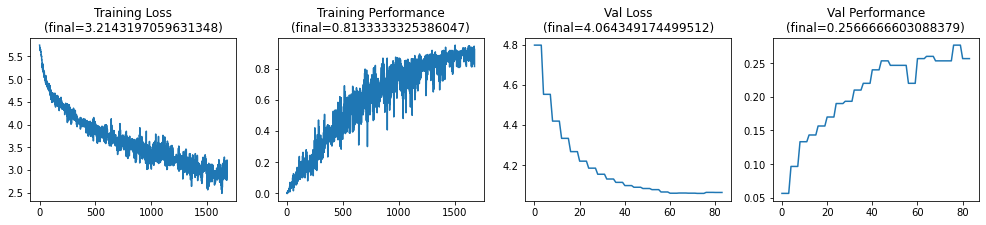

In [73]:
# Loading 
ckpt_path = 'checkpoints/clip_image_vit_subj01_epoch20.pth' 
checkpoint = torch.load(ckpt_path, map_location=device)
print(f"Plotting results from {ckpt_path}")

train_losses=checkpoint['train_losses']
train_percent_correct=checkpoint['train_percent_correct']
val_losses=checkpoint['val_losses']
val_percent_correct=checkpoint['val_percent_correct']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(17,3))
ax1.set_title(f"Training Loss\n(final={train_losses[-1]})")
ax1.plot(train_losses)
ax2.set_title(f"Training Performance\n(final={train_percent_correct[-1]})")
ax2.plot(train_percent_correct)
ax3.set_title(f"Val Loss\n(final={val_losses[-1]})")
ax3.plot(val_losses)
ax4.set_title(f"Val Performance\n(final={val_percent_correct[-1]})")
ax4.plot(val_percent_correct)
plt.show()

# Evaluating Top-K Image Retrieval

Restart kernel, run "import packages & functions" and "initialize network" cells, and then run below cells.

In [67]:
num_samples = 492
batch_size = 300
num_batches = 1
num_workers = 1
num_worker_batches = 1

preproc_vox = transforms.Compose([transforms.ToTensor(),torch.nan_to_num])
preproc_img = transforms.Compose([
                    transforms.Resize(size=(224,224)),
                    transforms.Normalize(mean=mean,
                                         std=std),
                ])

url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar"
val_data = wds.DataPipeline([wds.ResampledShards(url),
                    wds.tarfile_to_samples(),
                    wds.decode("torch"),
                    wds.rename(images="jpg;png", voxels="nsdgeneral.npy", 
                                embs="sgxl_emb.npy", trial="trial.npy"),
                    wds.map_dict(images=preproc_img),
                    wds.to_tuple("voxels", "images", "trial"),
                    wds.batched(batch_size, partial=True),
                ]).with_epoch(num_worker_batches)
val_dl = wds.WebLoader(val_data, num_workers=num_workers,
                       batch_size=None, shuffle=False, persistent_workers=True)

In [68]:
clip_model, _ = clip.load("ViT-L/14", device=device)
resnet_model, _ = clip.load("RN50", device=device)
clip_model.eval()
resnet_model.eval()

f = h5py.File('/scratch/gpfs/KNORMAN/nsdgeneral_hdf5/COCO_73k_subj_indices.hdf5', 'r')
subj01_order = f['subj01'][:]
f.close()

# curated the COCO annotations in the same way as the mind_reader (Lin Sprague Singh) preprint
annots = np.load('/scratch/gpfs/KNORMAN/nsdgeneral_hdf5/COCO_73k_annots_curated.npy',allow_pickle=True)
subj01_annots = annots[subj01_order]

def text_tokenize(annots):
    for i,b in enumerate(annots):
        t = ''
        while t == '':
            rand = torch.randint(5,(1,1))[0][0]
            t = b[0,rand]
        if i==0:
            txt = np.array(t)
        else:
            txt = np.vstack((txt,t))
    txt = txt.flatten()
    return clip.tokenize(txt)

def clip_text_embedder(text_token):
    with torch.no_grad():
        text_features = clip_model.encode_text(text_token.to(device))
    return text_features

def clip_image_embedder(image):
    with torch.no_grad():
        image_features = clip_model.encode_image(image.to(device))
        image_features = torch.clamp(image_features,-1.5,1.5) 
    return image_features    

def resnet_image_embedder(image):
    with torch.no_grad():
        image_features = resnet_model.encode_image(image.to(device))
    return image_features   

In [69]:
brain_net = BrainNetwork(768) 

brain_net_clip_img = brain_net.to(device)
checkpoint = torch.load('checkpoints/clip_image_vit_subj01_epoch20.pth', map_location=device)
brain_net_clip_img.load_state_dict(checkpoint['model_state_dict'])
brain_net_clip_img.eval()

brain_net_clip_text = brain_net.to(device)
checkpoint = torch.load('checkpoints/clip_text_vit_subj01_epoch20.pth', map_location=device)
brain_net_clip_text.load_state_dict(checkpoint['model_state_dict'])
brain_net_clip_text.eval()

brain_net = BrainNetwork(1024) 
brain_net_resnet_img = brain_net.to(device)
checkpoint = torch.load('checkpoints/clip_image_resnet_subj01_epoch42.pth', map_location=device)
brain_net_resnet_img.load_state_dict(checkpoint['model_state_dict'])
brain_net_resnet_img.eval()

BrainNetwork(
  (conv): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
    (1): Dropout1d(p=0.1, inplace=False)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lin): Linear(in_features=7861, out_features=7861, bias=True)
  (relu): ReLU()
  (lin1): Linear(in_features=251552, out_features=1024, bias=True)
)

CLIP IMG
percent_correct tensor(0.1333, device='cuda:0')


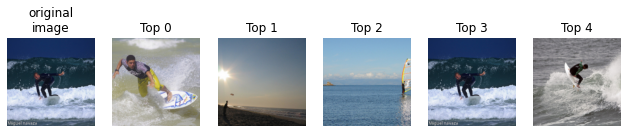

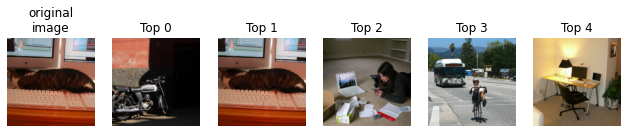

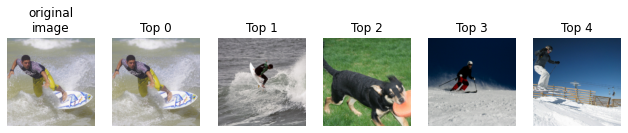

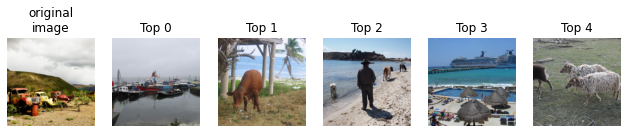


RESNET50 IMG
percent_correct tensor(0.3567, device='cuda:0')


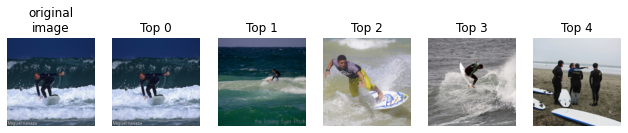

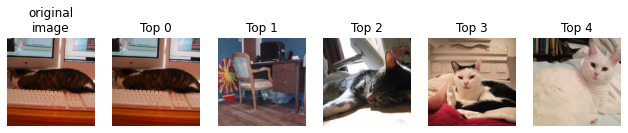

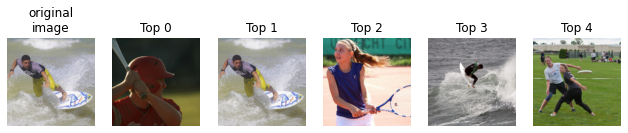

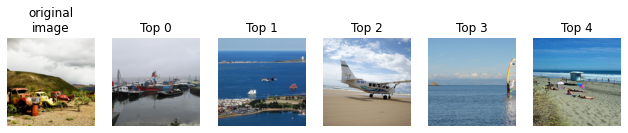


CLIP TEXT
percent_correct tensor(0.1633, device='cuda:0')


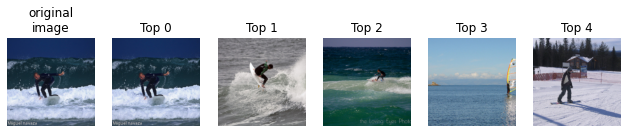

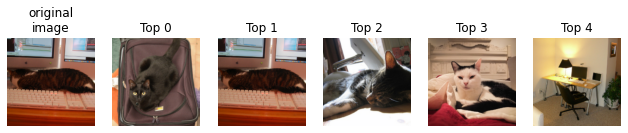

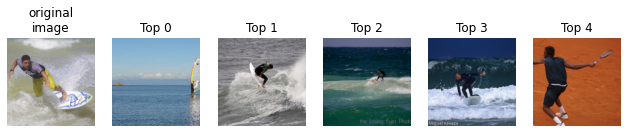

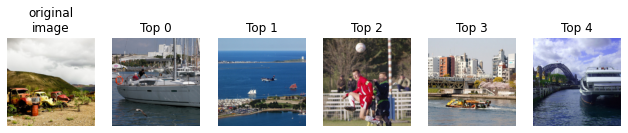


COMBINED
percent_correct tensor(0.3833, device='cuda:0')


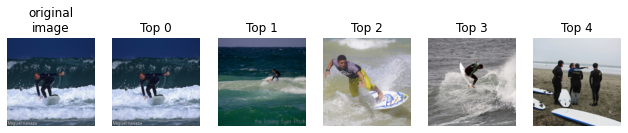

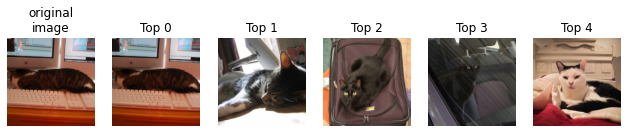

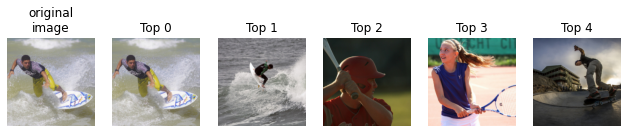

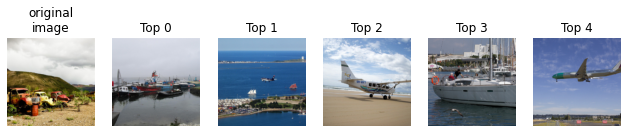

In [70]:
minibatch = 10 # using minibatches to be able to run evaluation on weaker gpu
for train_i, (voxel, emb, trial_idx) in enumerate(val_dl):
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            voxel = voxel.to(device)
            embt = text_tokenize(subj01_annots[trial_idx]).to(device)
            
            emb0=[]; emb1 = []; emb2 =[]
            for m in np.arange(0,batch_size,minibatch):
                if m==0:
                    emb0 = clip_image_embedder(emb[m:m+minibatch]).detach().cpu()
                    emb1 = resnet_image_embedder(emb[m:m+minibatch]).detach().cpu()
                    emb2 = clip_text_embedder(embt[m:m+minibatch]).detach().cpu()
                else:
                    emb0 = torch.vstack((emb0,clip_image_embedder(emb[m:m+minibatch]).detach().cpu()))
                    emb1 = torch.vstack((emb1,resnet_image_embedder(emb[m:m+minibatch]).detach().cpu()))
                    emb2 = torch.vstack((emb2,clip_text_embedder(embt[m:m+minibatch]).detach().cpu()))

            emb0 = emb0.to(device)
            emb1 = emb1.to(device)
            emb2 = emb2.to(device)
            
            emb_0 = brain_net_clip_img(voxel)
            emb_1 = brain_net_resnet_img(voxel)
            emb_2 = brain_net_clip_text(voxel)
            
            labels = torch.arange(len(emb0)).to(device)
            similarities0 = batchwise_cosine_similarity(emb0,emb_0)
            similarities1 = batchwise_cosine_similarity(emb1,emb_1)
            similarities2 = batchwise_cosine_similarity(emb2,emb_2)
            
            # how to combine the different models?
            similaritiesx = similarities0/2+similarities1+similarities2/2

            print("CLIP IMG")
            
            percent_correct = topk(similarities0,labels,k=1)
            print("percent_correct",percent_correct)
            
            similarities0=np.array(similarities0.detach().cpu())
            for trial in range(4):
                fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(11,6))
                ax[0].imshow(torch_to_Image(emb[trial]))
                ax[0].set_title("original\nimage")
                ax[0].axis("off")
                for attempt in range(5):
                    which = np.flip(np.argsort(similarities0[trial]))[attempt]
                    ax[attempt+1].imshow(torch_to_Image(emb[which]))
                    ax[attempt+1].set_title(f"Top {attempt}")
                    ax[attempt+1].axis("off")
                plt.show()
                
            print("\nRESNET50 IMG")
            
            percent_correct = topk(similarities1,labels,k=1)
            print("percent_correct",percent_correct)
            
            similarities1=np.array(similarities1.detach().cpu())
            for trial in range(4):
                fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(11,6))
                ax[0].imshow(torch_to_Image(emb[trial]))
                ax[0].set_title("original\nimage")
                ax[0].axis("off")
                for attempt in range(5):
                    which = np.flip(np.argsort(similarities1[trial]))[attempt]
                    ax[attempt+1].imshow(torch_to_Image(emb[which]))
                    ax[attempt+1].set_title(f"Top {attempt}")
                    ax[attempt+1].axis("off")
                plt.show()
                
            print("\nCLIP TEXT")
            
            percent_correct = topk(similarities2,labels,k=1)
            print("percent_correct",percent_correct)
            
            similarities2=np.array(similarities2.detach().cpu())
            for trial in range(4):
                fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(11,6))
                ax[0].imshow(torch_to_Image(emb[trial]))
                ax[0].set_title("original\nimage")
                ax[0].axis("off")
                for attempt in range(5):
                    which = np.flip(np.argsort(similarities2[trial]))[attempt]
                    ax[attempt+1].imshow(torch_to_Image(emb[which]))
                    ax[attempt+1].set_title(f"Top {attempt}")
                    ax[attempt+1].axis("off")
                plt.show()
                
            print("\nCOMBINED")
            
            percent_correct = topk(similaritiesx,labels,k=1)
            print("percent_correct",percent_correct)
            
            similaritiesx=np.array(similaritiesx.detach().cpu())
            for trial in range(4):
                fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(11,6))
                ax[0].imshow(torch_to_Image(emb[trial]))
                ax[0].set_title("original\nimage")
                ax[0].axis("off")
                for attempt in range(5):
                    which = np.flip(np.argsort(similaritiesx[trial]))[attempt]
                    ax[attempt+1].imshow(torch_to_Image(emb[which]))
                    ax[attempt+1].set_title(f"Top {attempt}")
                    ax[attempt+1].axis("off")
                plt.show()